# Data Loan Project
## Goal :
The project aims to create machine learning to predict whether a loan is **good** or **risky**.

## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import math
import scipy

plt.rcParams["figure.figsize"] = (10, 5)

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score
)

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

import warnings

warnings.filterwarnings("ignore")  # Settings the warnings to be ignored

# Settings pandas display
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## Load dataset

In [2]:
filename_data = "loan_data_2007_2014.csv.gz"

loans = pd.read_csv(
    os.path.join(os.getcwd(), "data", filename_data), index_col=0, compression="gzip"
)

## Data understanding

In [4]:
# Searching for type of data and also known the shape of data
loans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13  annu

> - Obtained that the dataset has 466285 rows and 74 columns
> - There are no values in columns `annual_inc_joint`, `dti_joint`, `verification_status_joint`, `open_acc_6m`, `open_il_6m`, `open_il_12m`, `open_il_24m`, `mths_since_rcnt_il`, `total_bal_il`, `il_util`, `open_rv_12m`, `open_rv_24m`, `max_bal_bc`, `all_util`, `inq_fi`, `total_cu_tl`, and `inq_last_12m`. So it will be deleted.

In [5]:
# Looking unique values
loans.nunique()

id                             466285
member_id                      466285
loan_amnt                        1352
funded_amnt                      1354
funded_amnt_inv                  9854
term                                2
int_rate                          506
installment                     55622
grade                               7
sub_grade                          35
emp_title                      205475
emp_length                         11
home_ownership                      6
annual_inc                      31901
verification_status                 3
issue_d                            91
loan_status                         9
pymnt_plan                          2
url                            466285
desc                           124435
purpose                            14
title                           63098
zip_code                          888
addr_state                         50
dti                              3997
delinq_2yrs                        24
earliest_cr_

There is only one unique value in columns `policy_code` and `application_type`. So it will be deleted.

In [6]:
# Looking at the first 3 data
loans.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1077501,1296599,5000,5000,4975.000,36 months,10.650,162.870,B,B2,NaN,10+ years,RENT,24000.000,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.650,0.000,Jan-85,1.000,NaN,NaN,3.000,0.000,13648,83.700,9.000,f,0.000,0.000,5861.071,5831.780,5000.000,861.070,0.000,0.000,0.000,Jan-15,171.620,NaN,Jan-16,0.000,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.000,60 months,15.270,59.830,C,C4,Ryder,< 1 year,RENT,30000.000,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.000,0.000,Apr-99,5.000,NaN,NaN,3.000,0.000,1687,9.400,4.000,f,0.000,0.000,1008.710,1008.710,456.460,435.170,0.000,117.080,1.110,Apr-13,119.660,NaN,Sep-13,0.000,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.000,36 months,15.960,84.330,C,C5,NaN,10+ years,RENT,12252.000,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.720,0.000,Nov-01,2.000,NaN,NaN,2.000,0.000,2956,98.500,10.000,f,0.000,0.000,3003.654,3003.650,2400.000,603.650,0.000,0.000,0.000,Jun-14,649.910,NaN,Jan-16,0.000,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Summary statistic for numerical columns
loans.describe().T

,count,mean,std,min,25%,50%,75%,max
id,466285.000,13079729.906,10893711.625,54734.000,3639987.000,10107897.000,20731209.000,38098114.000
member_id,466285.000,14597660.623,11682367.441,70473.000,4379705.000,11941075.000,23001541.000,40860827.000
loan_amnt,466285.000,14317.278,8286.509,500.000,8000.000,12000.000,20000.000,35000.000
funded_amnt,466285.000,14291.801,8274.371,500.000,8000.000,12000.000,20000.000,35000.000
funded_amnt_inv,466285.000,14222.330,8297.638,0.000,8000.000,12000.000,19950.000,35000.000
int_rate,466285.000,13.829,4.358,5.420,10.990,13.660,16.490,26.060
installment,466285.000,432.061,243.486,15.670,256.690,379.890,566.580,1409.990
annual_inc,466281.000,73277.381,54963.569,1896.000,45000.000,63000.000,88960.000,7500000.000
dti,466285.000,17.219,7.851,0.000,11.360,16.870,22.780,39.990
delinq_2yrs,466256.000,0.285,0.797,0.000,0.000,0.000,0.000,29.000


- `loan_amnt` : the average number of loans is 14203.701, with a range of 500 to 35000
- `int_rate` : the average of interest rate is 13.733, with a range of 5.420 to 26.060
- `installment` : the average installment is 428.221, with a range of 15.670 to	1409.990
- `annual_inc` : the average of annual income is 72831.694, with a range of 1896 to 7500000
- `dti` : the average of debt-to-income ratio is 17.175, with a range of 0 to 39.99
- `total_pymnt` : the average of total payment is 11585.831, with a range of 0 to 57777.58

> There are enough outliers in the data

## Exploratory Data Analysis (EDA)

To ease data exploration :
- Columns that contained **entirely null values** will be removed
- Columns that **had only 1 unique value** will be **removed**
- `id` and `member_id` will be removed as they do not affect the modeling

In [8]:
# Removing 0 non null columns
zero_non_null = [
  'annual_inc_joint',
  'dti_joint',
  'verification_status_joint',
  'open_acc_6m',
  'open_il_6m',
  'open_il_12m',
  'open_il_24m',
  'mths_since_rcnt_il',
  'total_bal_il',
  'il_util',
  'open_rv_12m',
  'open_rv_24m',
  'max_bal_bc',
  'all_util',
  'inq_fi',
  'total_cu_tl',
  'inq_last_12m',
]

loans = loans.drop(zero_non_null, axis=1)

In [9]:
# Removing single value columns
single_val_cols = []
for col in loans.columns:
    non_null = loans[col].dropna()
    unique_non_null = non_null.unique()
    num_true_unique = len(unique_non_null)
    if num_true_unique < 2:
        single_val_cols.append(col)

loans = loans.drop(single_val_cols, axis=1)

In [10]:
# Removing id and member_id columns
loans = loans.drop(columns=["id", "member_id"], axis=1)

In [11]:
num_cols = loans.select_dtypes(include=["int", "float"]).columns.to_list()

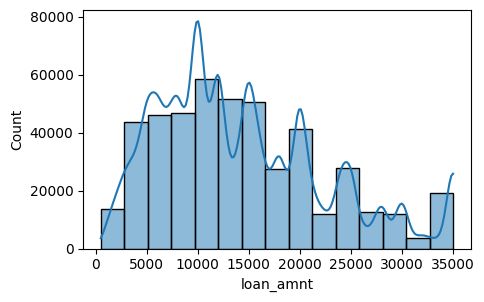

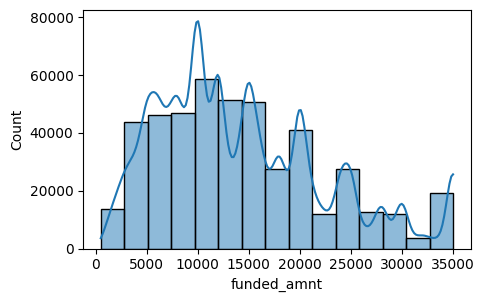

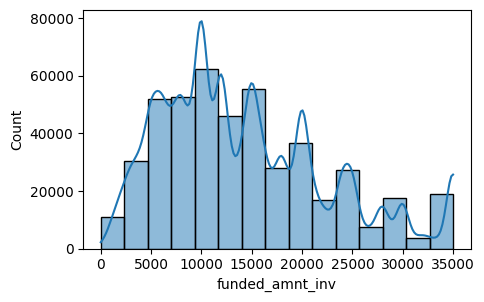

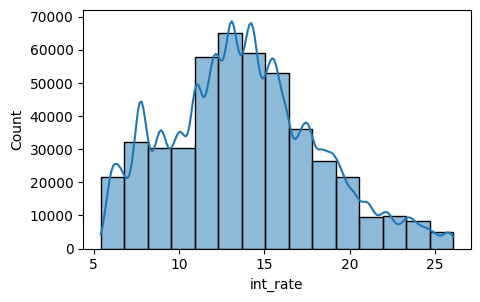

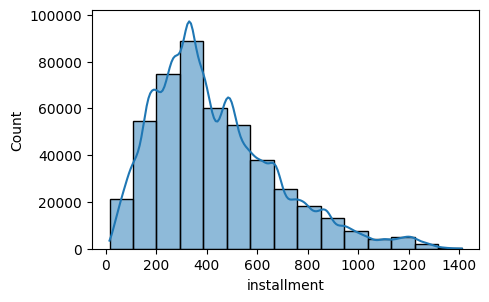

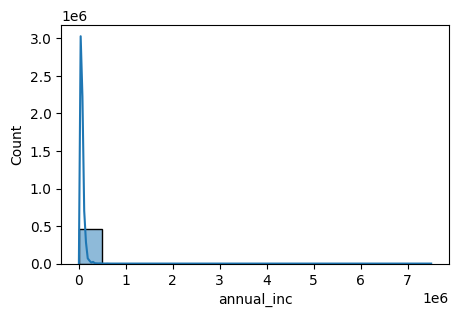

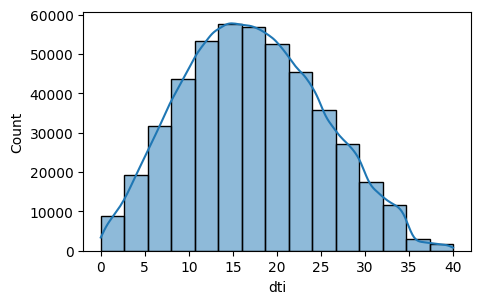

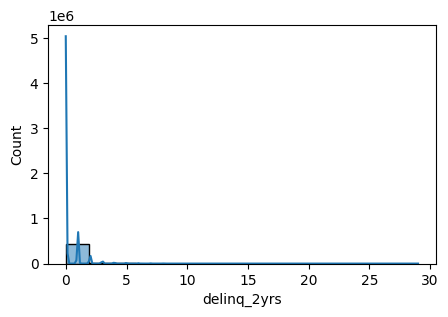

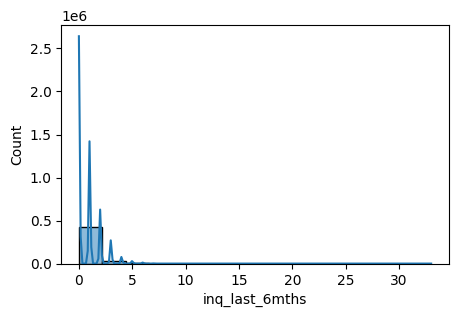

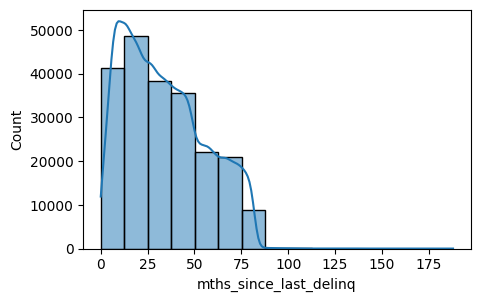

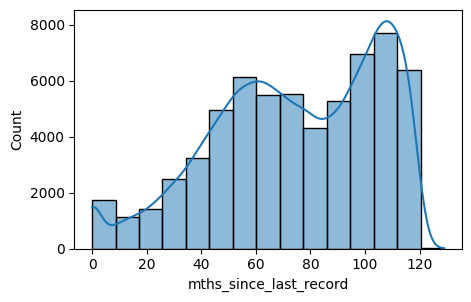

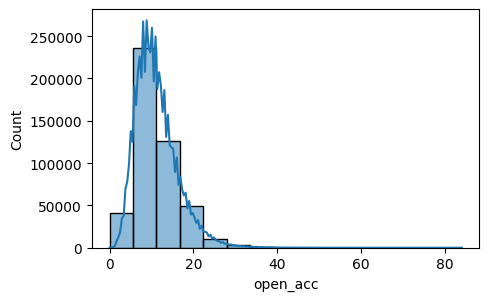

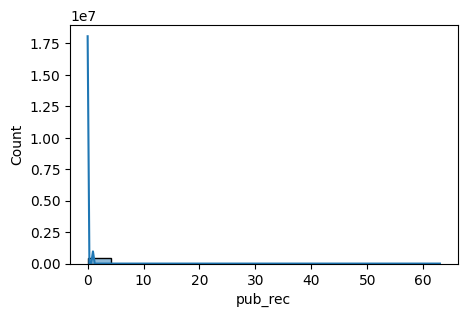

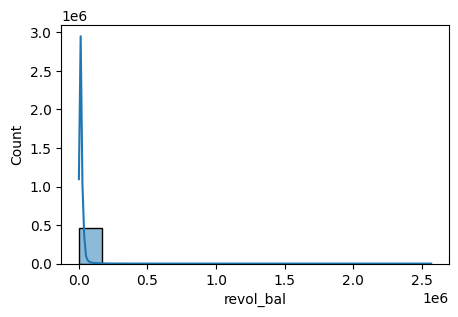

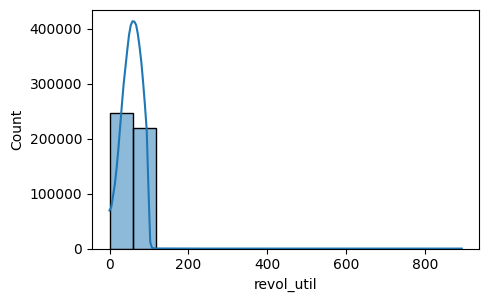

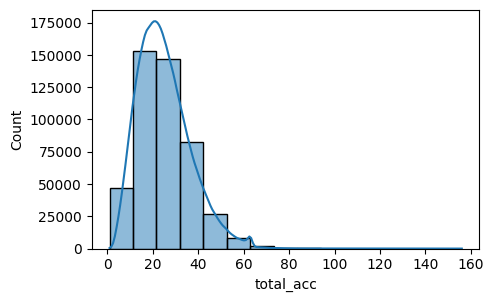

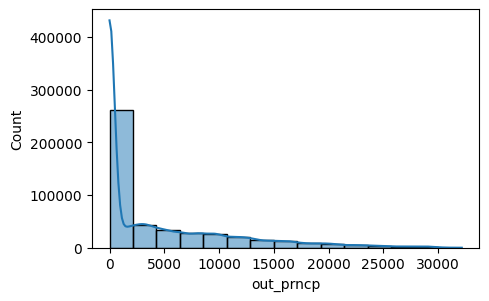

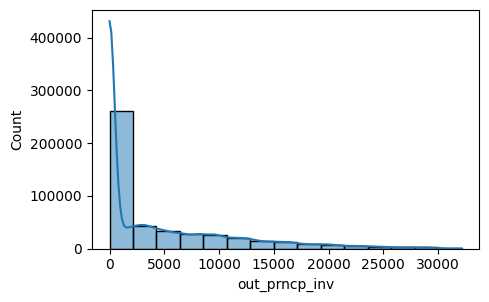

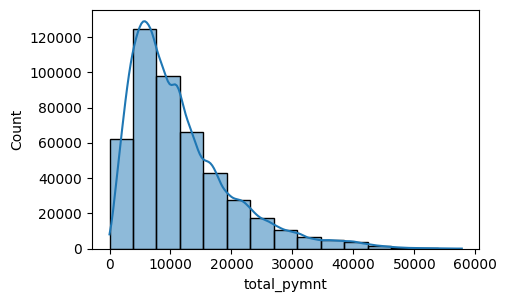

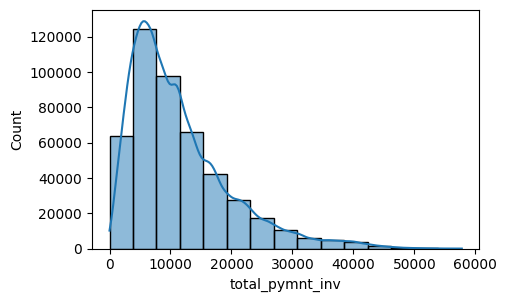

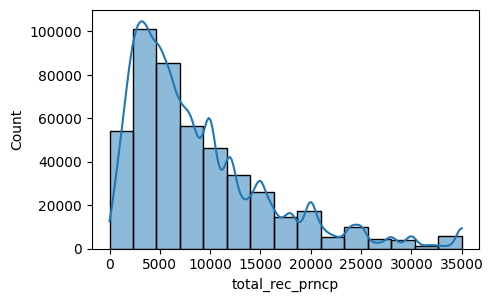

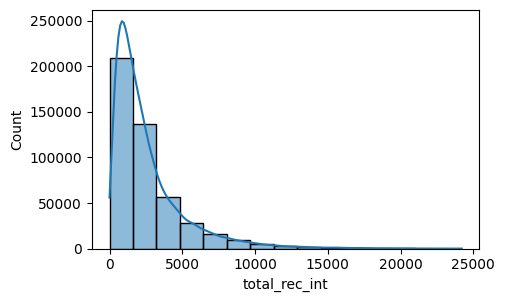

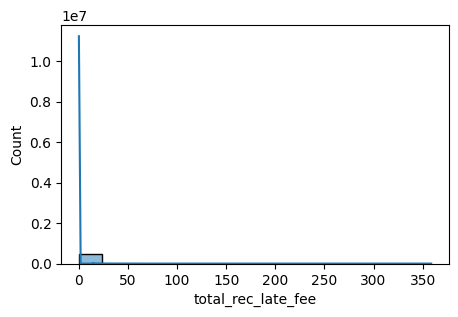

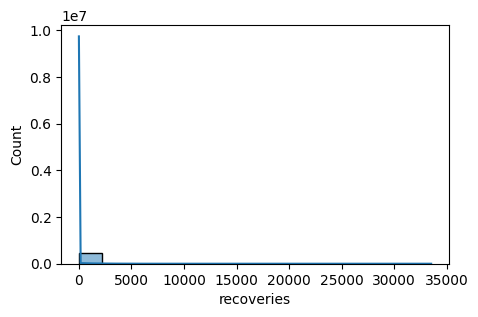

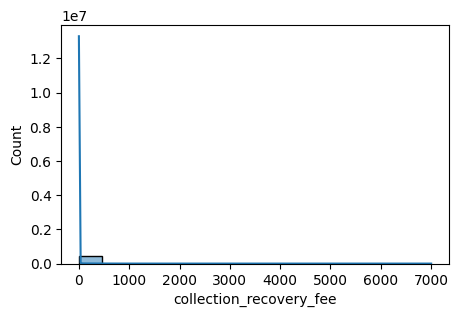

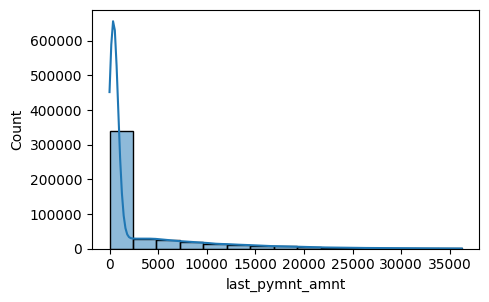

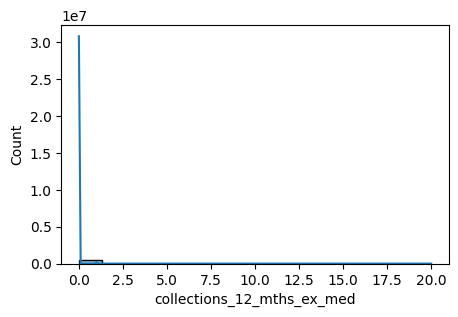

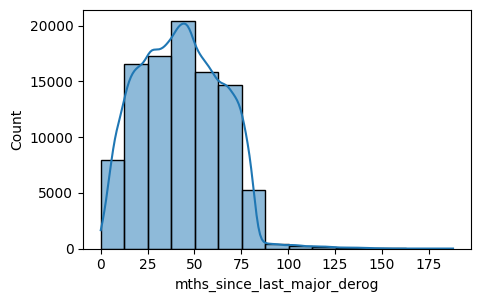

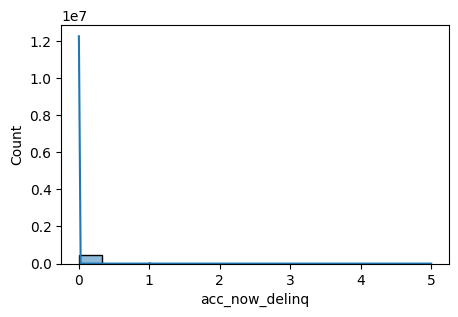

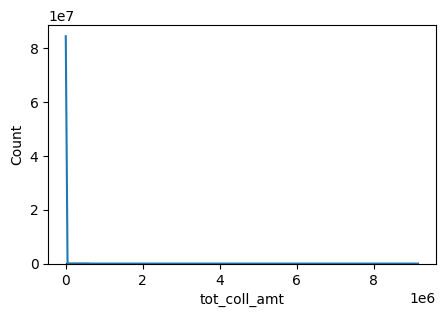

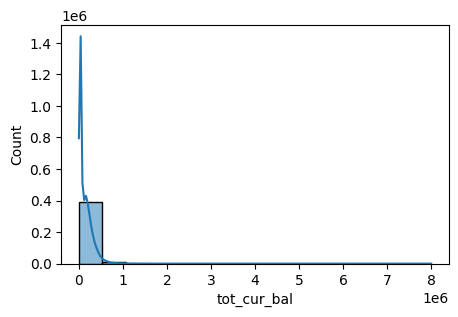

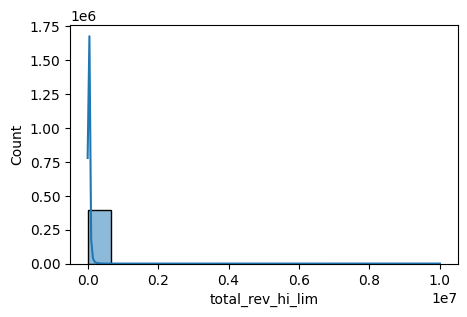

In [12]:
# Distribution of numeric columns
for col in num_cols:
    fig, ax = plt.subplots(figsize=(5,3.1))
    sns.histplot(loans[col], bins=15, kde=True)
    plt.show()

> - Column with **normal** distribution : `dti`
> - Column with **right-skewed** distribution : `loan_amnt`, `funded_amnt`, `int_rate`, `funded_amnt_inv`, `mths_since_last_delinq`, `open_acc`, `total_acc`, `out_prncp`, `out_prncp_inv`, `total_pymnt`, `total_pymnt_inv`, `total_rec_prncp`, `total_rec_int`, `last_pymnt_amnt`, `mths_since_last_major_derog`
> - Column with **left-skewed** distribution : `mths_since_last_record`
> - Column with **not well** distribution : `annual_inc`, `delinq_2yrs`, `inq_last_6mths`, `pub_rec`, `revol_bal`, `revol_util`, `total_rec_late_fee`, `recoveries`, `collection_recovery_fee`, `collections_12_mths_ex_med`, `acc_now_delinq`, `tot_coll_amt`, `tot_cur_bal`, `total_rev_hi_lim`

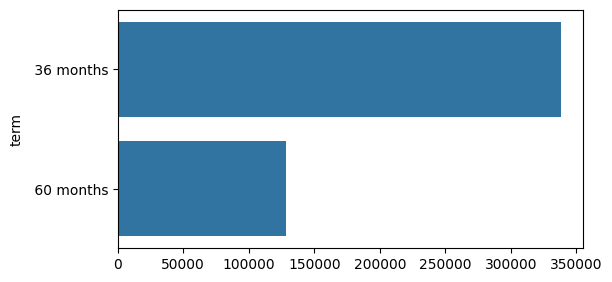

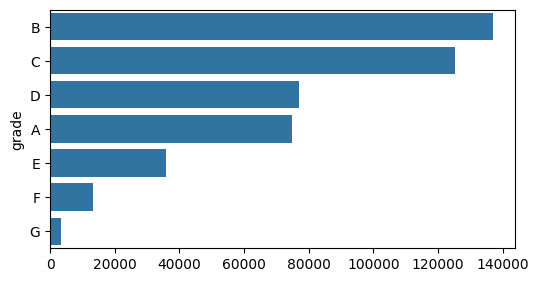

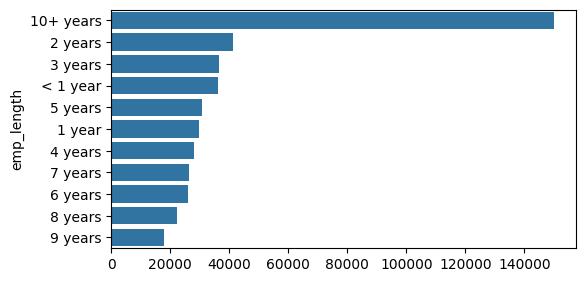

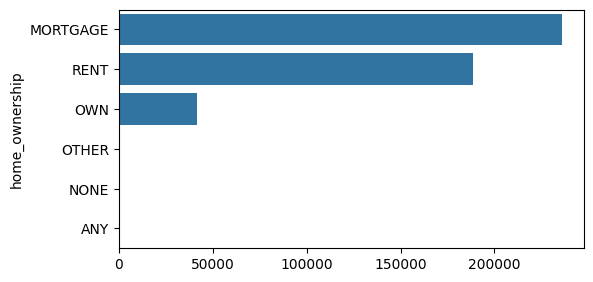

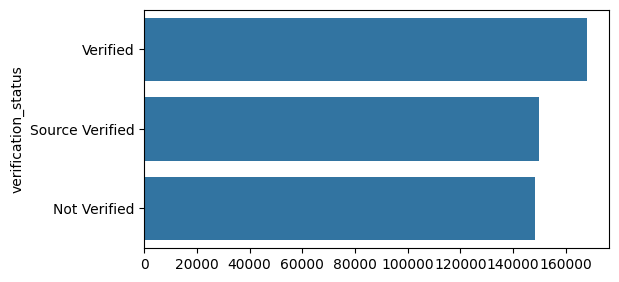

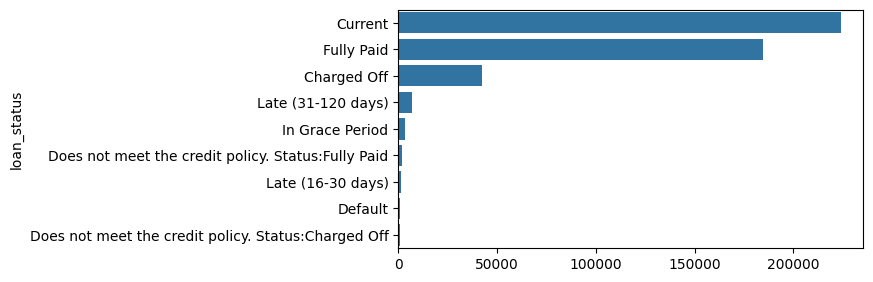

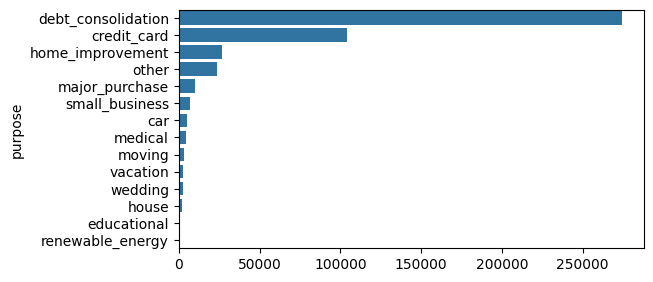

In [13]:
# Distribution of some categorical columns
cat_cols = [
    'term',
    'grade',
    'emp_length',
    'home_ownership',
    'verification_status',
    'loan_status',
    'purpose'
]

for col in cat_cols:
    counter = loans[col].value_counts()

    fig, ax = plt.subplots(figsize=(6, 3.1))
    sns.barplot(x=counter.values, y=counter.index, orient="h")
    plt.show()

> - The majority choose **36 month installments**
> - **The most** borrowed grade is **grade B** and **the least** is **grade G**
> - Borrowers are dominated by workers with **more than 10 years** of service
> - Most home ownership statuses are **mortgages**, followed by **rent**
> - The number of borrower statuses is **almost balanced**
> - Most of the loan status is **current** and **fully paid**, with **charged off in third place**
> - The purpose of most loans is for **debt consolidation**

In [14]:
# Top 5 emp_title
loans.emp_title.value_counts().head()

emp_title
Teacher             5399
Manager             4438
Registered Nurse    2316
RN                  2204
Supervisor          1967
Name: count, dtype: int64

In [15]:
# Top 5 issue_d
loans.issue_d.value_counts().head()

issue_d
Oct-14    38782
Jul-14    29306
Nov-14    25054
May-14    19099
Apr-14    19071
Name: count, dtype: int64

> - The most common occupation of borrowers is **teacher**
> - Most funded in **October 2014**

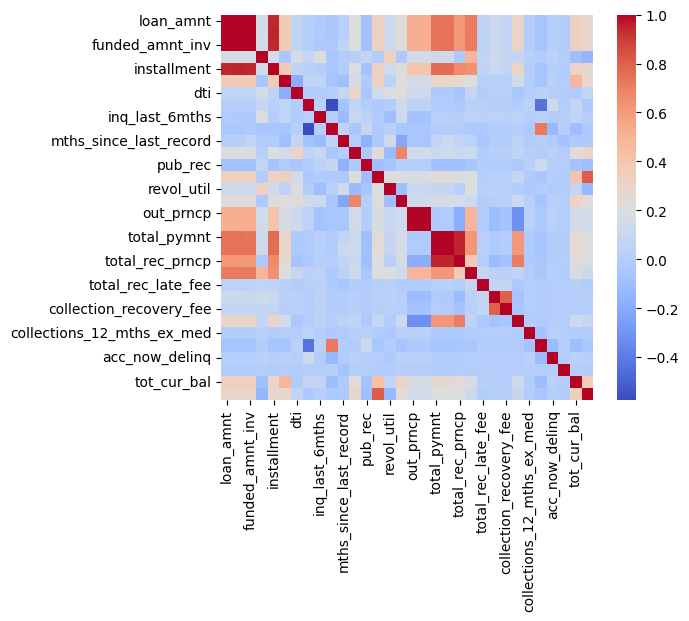

In [16]:
# Correlation each numeric column
loans_corr = loans[num_cols].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(loans_corr, cmap="coolwarm")
plt.show()

Most columns are uncorrelated or weakly correlated with each other

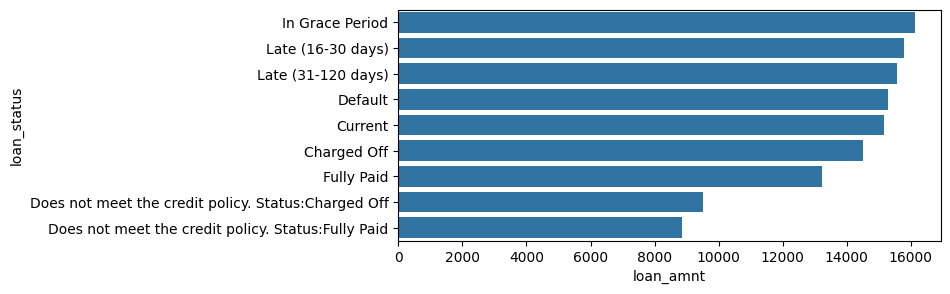

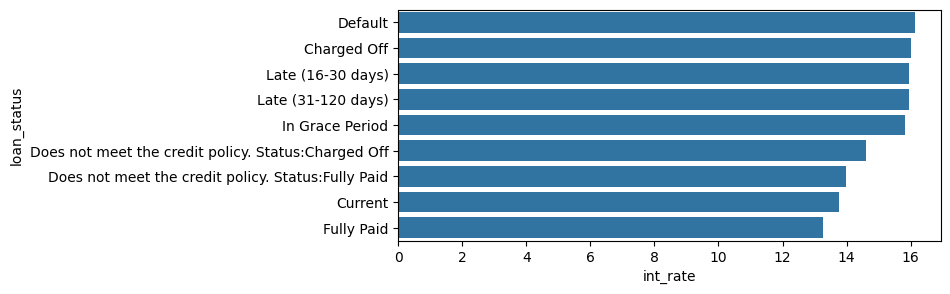

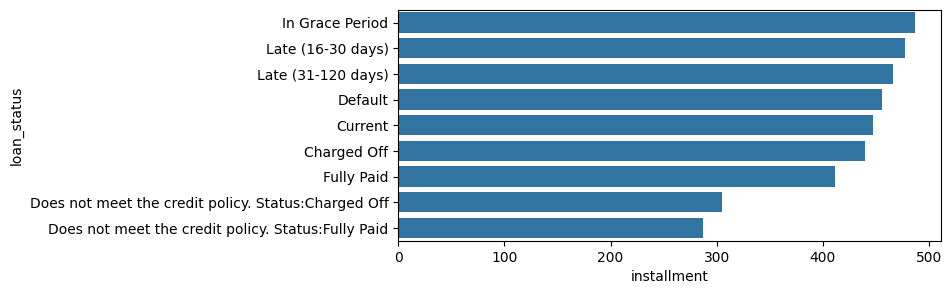

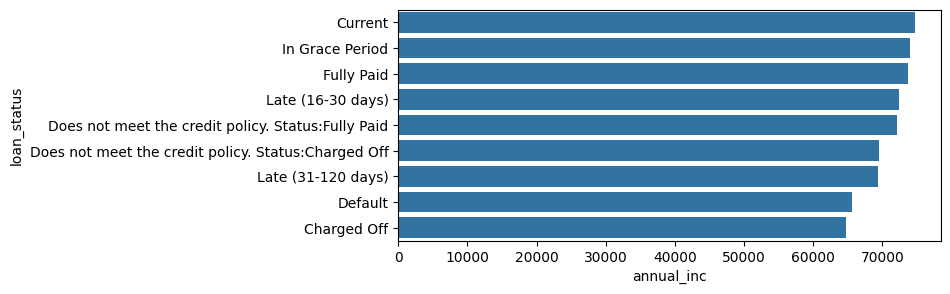

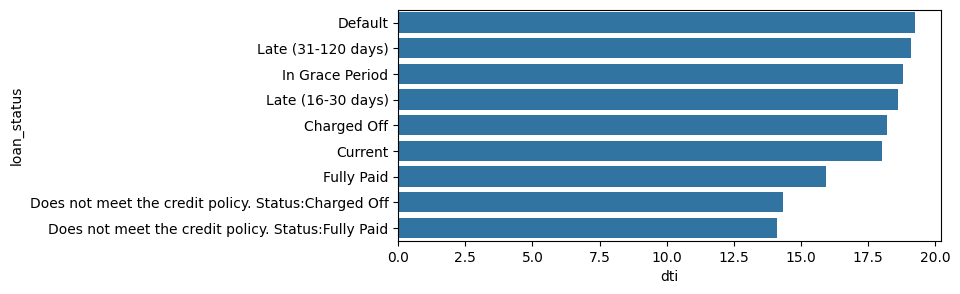

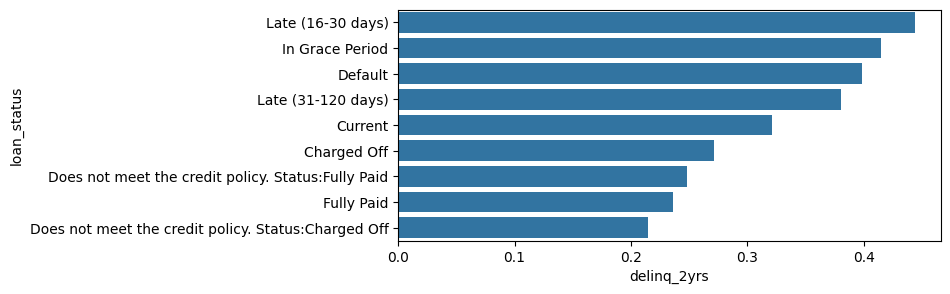

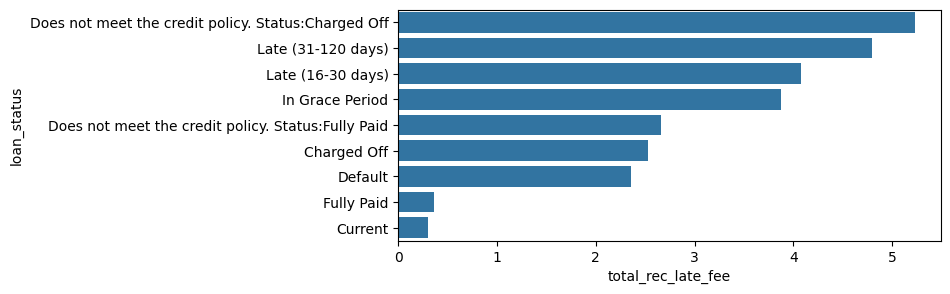

In [17]:
# Average of some numerical columns by loan_status
cols = [
    "loan_amnt",
    "int_rate",
    "installment",
    "annual_inc",
    "dti",
    "delinq_2yrs",
    "total_rec_late_fee",
]

for col in cols:
  data_group = loans.groupby(["loan_status"])[col].mean().sort_values(ascending=False)

  plt.figure(figsize=(7,3))
  sns.barplot(data=pd.DataFrame(data_group), y=data_group.index, x=data_group.values)
  plt.xlabel(col)
  plt.show()

- The highest average `loan_amnt` has a status **in grace period**, followed by **Late**, **Default**, while **fully_paid** is in **7th** position.
- fully_paid status has the smallest average interest rate (`int_rate`)
- Same as `loan_amnt`, the **fully_paid** status is in the **7th** position of the highest average `installment`
- Borrowers with annual income (`annual_inc`) **less than 70000** have the potential to become **bad loans**
- Debt-to-income (`dti`) of **more than 17.5** is potentially a **bad loan**
- **Late status (16-30 days)** has the highest average `delinq_2yrs`

## Data preparation

### Define target column
Created a target column using the loan_status column. The value of **fully_paid** is categorized as a **good loan** which is **1**, while the values of **charged_off**, **Late (31-120 days)**, **Late (16-30 days**), and **Default** are categorized as **bad loans** which are **0**.

In [18]:
# Define the target column
mapping_target = {
    "loan_status": {
        "Fully Paid": 1,
        "Charged Off": 0,
        "Late (31-120 days)": 0,
        "Late (16-30 days)": 0,
        "Default": 0,
    }
}
loans = loans.replace(mapping_target)

# Delete column with loan_status value other than 0 or 1
loans = loans[
    (loans["loan_status"] == 0) | (loans["loan_status"] == 1)
].reset_index(drop=True)

Columns with **more than 10%** missing values will be **removed**, as this may affect the machine learning model to be less accurate

In [19]:
# Removing columns with null values more than 10%
missing_data = loans.isnull().sum()
loans = loans[
    loans[missing_data.index[missing_data.values < 0.1 * loans.shape[0]]].columns
]
loans.shape

(236164, 45)

In [20]:
# Looking for columns that have number of unique value less than 5
for col in loans.columns:
    if len(loans[col].unique()) < 5:
        print(loans[col].value_counts())
        print()

term
36 months    184031
60 months     52133
Name: count, dtype: int64

verification_status
Verified           88196
Not Verified       81187
Source Verified    66781
Name: count, dtype: int64

loan_status
1    184739
0     51425
Name: count, dtype: int64

pymnt_plan
n    236157
y         7
Name: count, dtype: int64

initial_list_status
f    174965
w     61199
Name: count, dtype: int64



There is an imbalance of data in the `pymnt_plan` column, so the column is deleted

In [21]:
# Delete pymnt_plan column
loans = loans.drop("pymnt_plan", axis=1)

In [22]:
loans.head(3)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq
0,5000,5000,4975.000,36 months,10.650,162.870,B,B2,NaN,10+ years,RENT,24000.000,Verified,Dec-11,1,https://www.lendingclub.com/browse/loanDetail....,credit_card,Computer,860xx,AZ,27.650,0.000,Jan-85,1.000,3.000,0.000,13648,83.700,9.000,f,0.000,0.000,5861.071,5831.780,5000.000,861.070,0.000,0.000,0.000,Jan-15,171.620,Jan-16,0.000,0.000
1,2500,2500,2500.000,60 months,15.270,59.830,C,C4,Ryder,< 1 year,RENT,30000.000,Source Verified,Dec-11,0,https://www.lendingclub.com/browse/loanDetail....,car,bike,309xx,GA,1.000,0.000,Apr-99,5.000,3.000,0.000,1687,9.400,4.000,f,0.000,0.000,1008.710,1008.710,456.460,435.170,0.000,117.080,1.110,Apr-13,119.660,Sep-13,0.000,0.000
2,2400,2400,2400.000,36 months,15.960,84.330,C,C5,NaN,10+ years,RENT,12252.000,Not Verified,Dec-11,1,https://www.lendingclub.com/browse/loanDetail....,small_business,real estate business,606xx,IL,8.720,0.000,Nov-01,2.000,2.000,0.000,2956,98.500,10.000,f,0.000,0.000,3003.654,3003.650,2400.000,603.650,0.000,0.000,0.000,Jun-14,649.910,Jan-16,0.000,0.000


Many columns are not important for this modeling, as **most columns** are **not correlated** with each other. **Some** of these columns will be **removed to reduce unimportant features**

In [23]:
# Removing unnecessary columns
loans = loans.drop(
    [
        "funded_amnt",
        "funded_amnt_inv",
        "sub_grade",
        "emp_title",
        "issue_d",
        "url",
        "addr_state",
        "earliest_cr_line",
        "initial_list_status",
        "out_prncp",
        "out_prncp_inv",
        "total_pymnt",
        "total_pymnt_inv",
        "total_rec_prncp",
        "total_rec_int",
        "collection_recovery_fee",
        "last_pymnt_d",
        "last_pymnt_amnt",
        "last_credit_pull_d",
        "collections_12_mths_ex_med",
        "acc_now_delinq",
    ],
    axis=1,
)

In [24]:
# Looking missing value
loans.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
grade                     0
emp_length             9191
home_ownership            0
annual_inc                0
verification_status       0
loan_status               0
purpose                   0
title                    14
zip_code                  0
dti                       0
delinq_2yrs               0
inq_last_6mths            0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util              192
total_acc                 0
total_rec_late_fee        0
recoveries                0
dtype: int64

In [25]:
# Handling missing value in categorical data
cat_missing = ["emp_length", "title"]
for col in cat_missing:
    print(loans[col].value_counts())
    print()

emp_length
10+ years    70842
2 years      22003
< 1 year     19526
3 years      19129
5 years      17125
1 year       15730
4 years      15197
6 years      14156
7 years      13366
8 years      10985
9 years       8914
Name: count, dtype: int64

title
Debt consolidation                  60371
Credit card refinancing             19586
Debt Consolidation                  11263
Home improvement                     5360
Other                                4932
                                    ...  
Lawn care                               1
finish det payoff                       1
Stop the bleeding                       1
LoanGetter                              1
Credit Consolidation 3-year plan        1
Name: count, Length: 48433, dtype: int64



- Missing values from the `emp_length` column are still **less than 10%**, the missing values will be **removed** because the distribution of data from this column is good enough for modeling
- `title` column has quite a lot of unique values and has a poor data distribution, to facilitate modeling this column will be **deleted**

In [26]:
# Handling emp_length column with deletion
loans = loans.dropna(subset="emp_length").reset_index(drop=True)

# Drop title and earliest columns
loans = loans.drop(["title"], axis=1)

In [27]:
# Handling missing value in numerical data with imputation ("revol_util")
loans["revol_util"] = loans["revol_util"].fillna(loans["revol_util"].mean())

### Handling outliers
To detect outliers, a plotting function taken from [Visualize Dataset](https://github.com/mhoogen/ML4QS/blob/master/Python3Code/util/VisualizeDataset.py). There will be two tests, one using the **interquartile range (IQR) method** and the other using the **Chauvennet criterion**.

In [28]:
# Plotting outliers
def plot_binary_outliers(dataset, col, outlier_col, reset_index):
    """Plot outliers in case of a binary outlier score. Here, the col specifies the real data
    column and outlier_col the columns with a binary value (outlier or not).

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): Column that you want to plot
        outlier_col (string): Outlier column marked with true/false
        reset_index (bool): whether to reset the index for plotting
    """

    # Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/util/VisualizeDataset.py

    dataset = dataset.dropna(axis=0, subset=[col, outlier_col])
    dataset[outlier_col] = dataset[outlier_col].astype("bool")

    if reset_index:
        dataset = dataset.reset_index()

    fig, ax = plt.subplots()

    plt.xlabel("samples")
    plt.ylabel("value")

    # Plot non outliers in default color
    ax.plot(
        dataset.index[~dataset[outlier_col]],
        dataset[col][~dataset[outlier_col]],
        "+",
    )
    # Plot data points that are outliers in red
    ax.plot(
        dataset.index[dataset[outlier_col]],
        dataset[col][dataset[outlier_col]],
        "r+",
    )

    plt.legend(
        ["no outlier " + col, "outlier " + col],
        loc="upper left",
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    plt.show()

In [29]:
# Marking outliers using IQR
def mark_outliers_iqr(dataset, col):
    """Function to mark values as outliers using the IQR method.

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()

    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    dataset[col + "_outlier"] = (dataset[col] < lower_bound) | (
        dataset[col] > upper_bound
    )

    return dataset

In [30]:
# Marking outliers using Chauvenet
def mark_outliers_chauvenet(dataset, col, C=2):
    """Finds outliers in the specified column of datatable and adds a binary column with
    the same name extended with '_outlier' that expresses the result per data point.

    Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/Chapter3/OutlierDetection.py

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        C (int, optional): Degree of certainty for the identification of outliers given the assumption
                           of a normal distribution, typicaly between 1 - 10. Defaults to 2.

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()
    # Compute the mean and standard deviation.
    mean = dataset[col].mean()
    std = dataset[col].std()
    N = len(dataset.index)
    criterion = 1.0 / (C * N)

    # Consider the deviation for the data points.
    deviation = abs(dataset[col] - mean) / std

    # Express the upper and lower bounds.
    low = -deviation / math.sqrt(C)
    high = deviation / math.sqrt(C)
    prob = []
    mask = []

    # Pass all rows in the dataset.
    for i in range(0, len(dataset.index)):
        # Determine the probability of observing the point
        prob.append(
            1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
        )
        # And mark as an outlier when the probability is below our criterion.
        mask.append(prob[i] < criterion)
    dataset[col + "_outlier"] = mask
    return dataset

In [31]:
outlier_cols = loans.select_dtypes(include=["int", "float"]).columns
outlier_cols

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_late_fee', 'recoveries'],
      dtype='object')

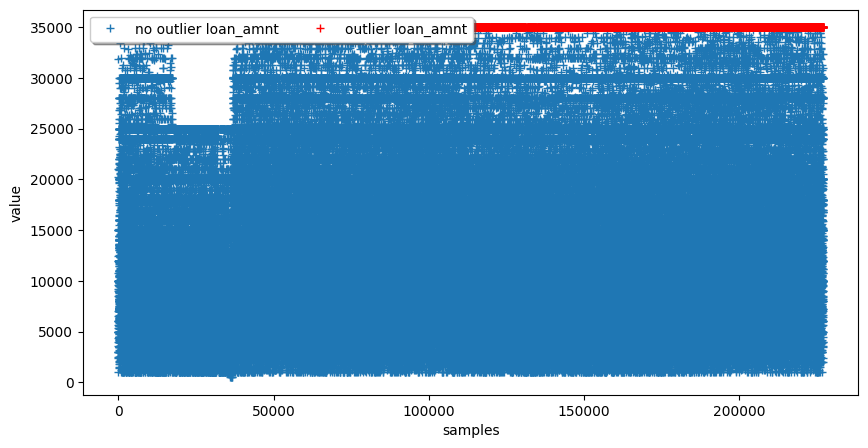

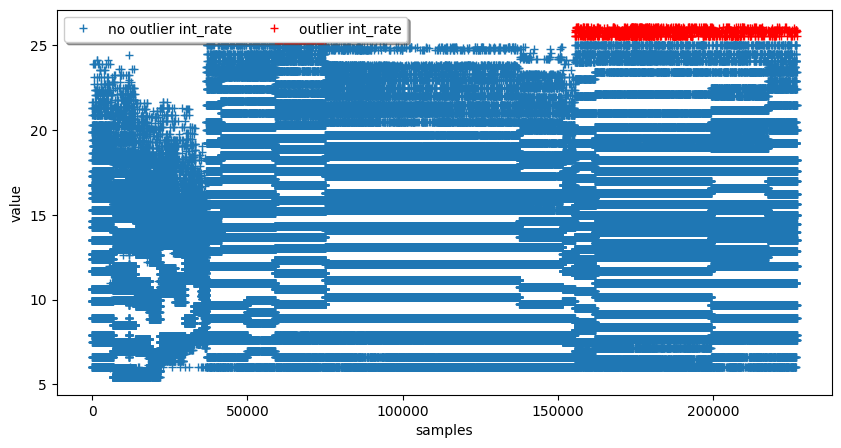

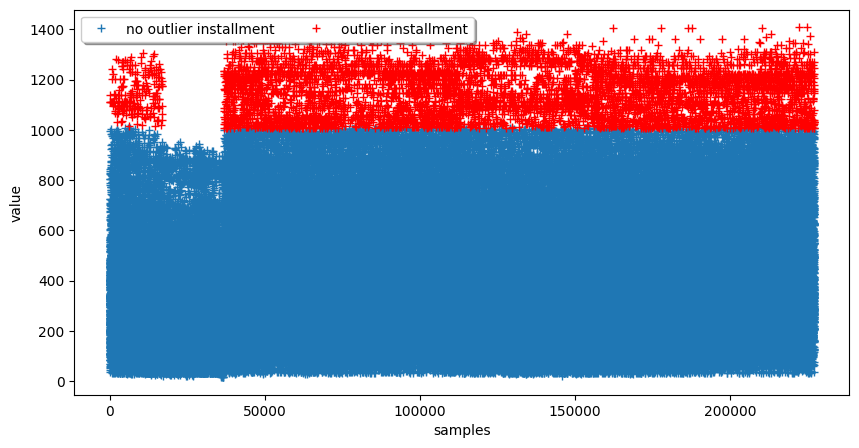

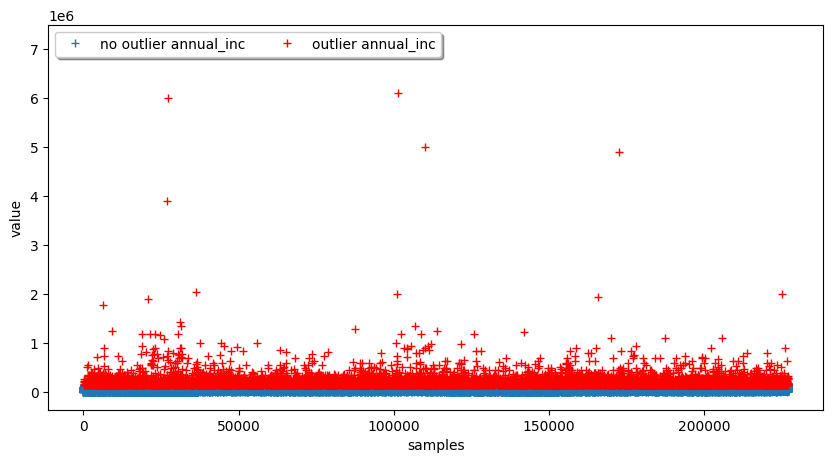

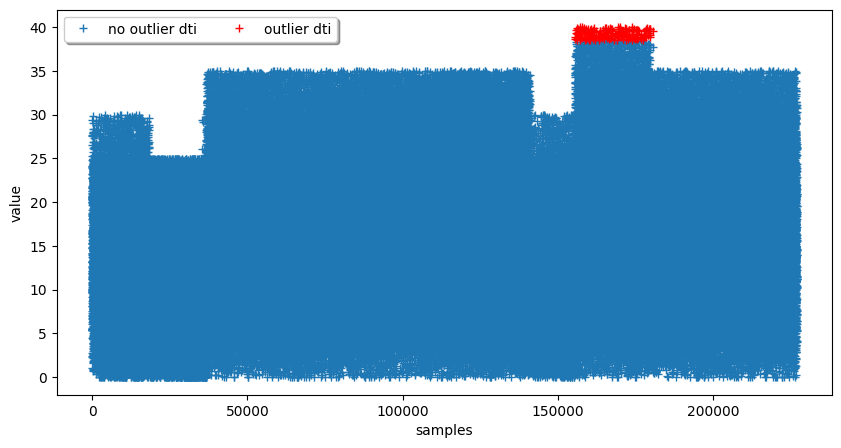

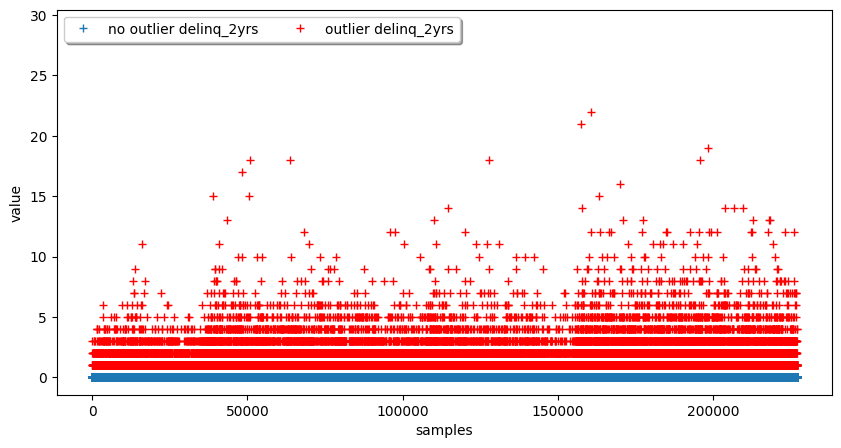

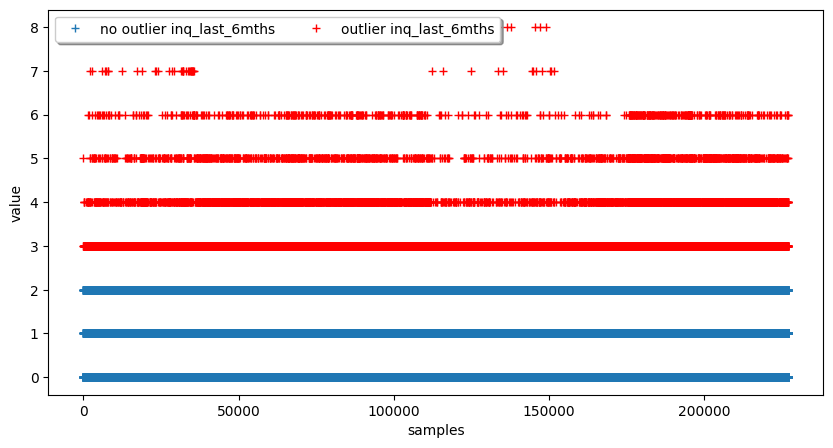

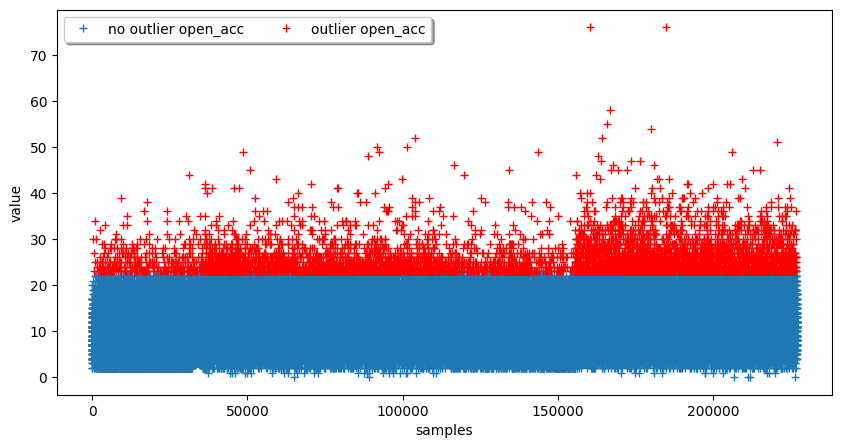

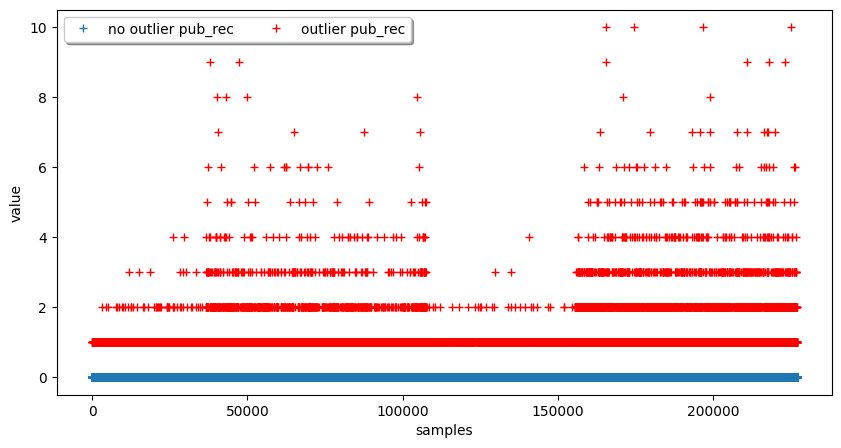

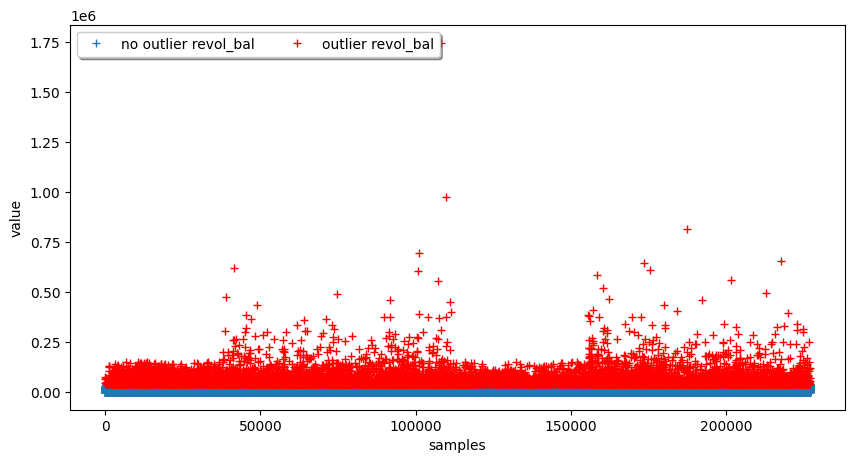

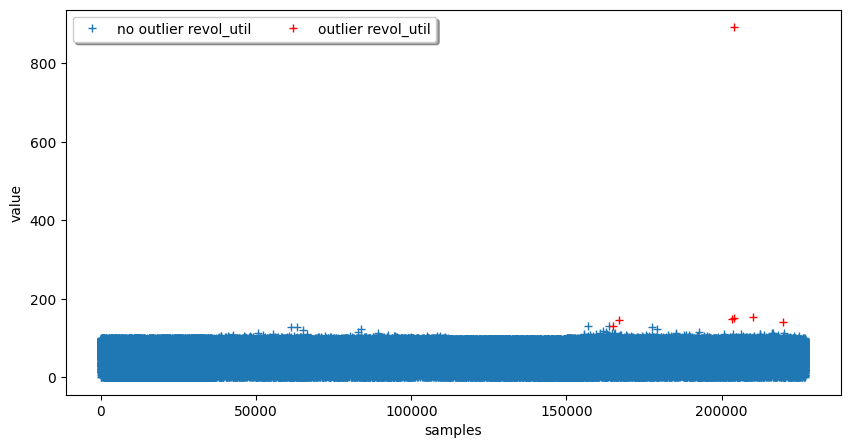

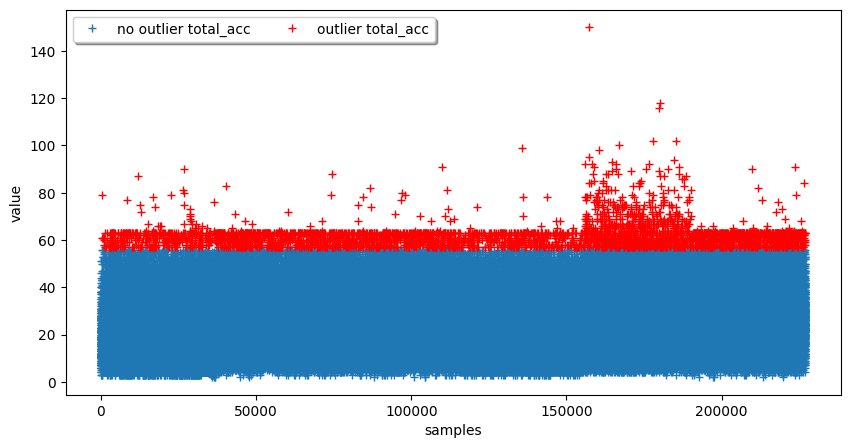

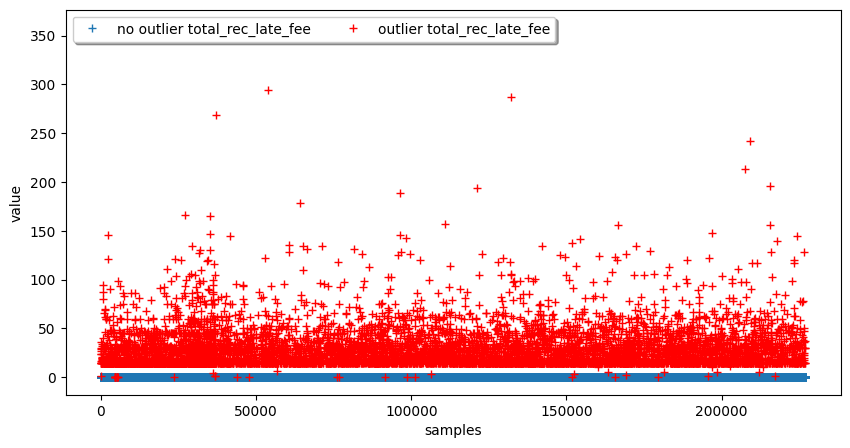

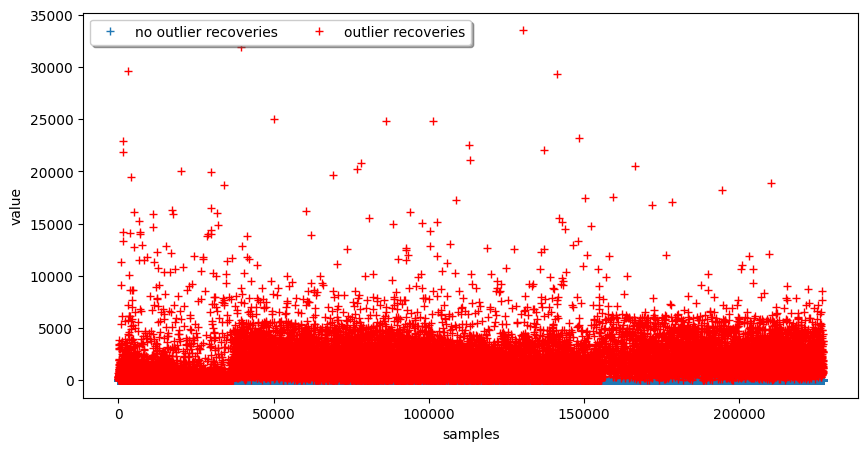

In [32]:
# Marking outlier for numeric columns using IQR
for col in outlier_cols:
    dataset = mark_outliers_iqr(loans, col)
    plot_binary_outliers(
        dataset=dataset, col=col, outlier_col=col + "_outlier", reset_index=False
    )

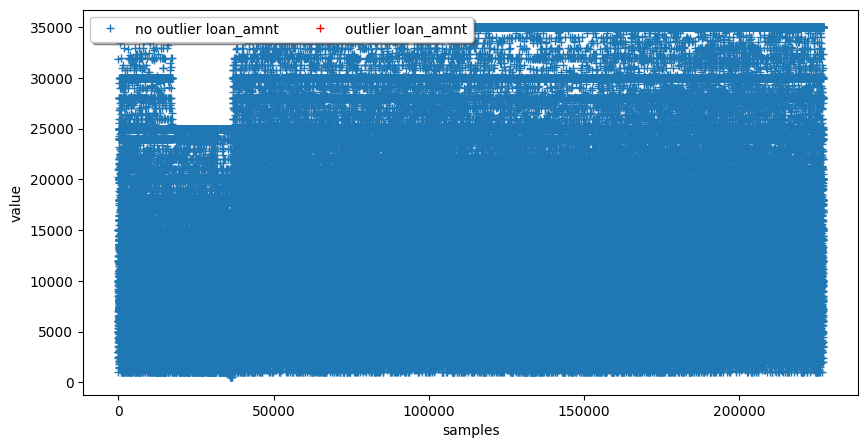

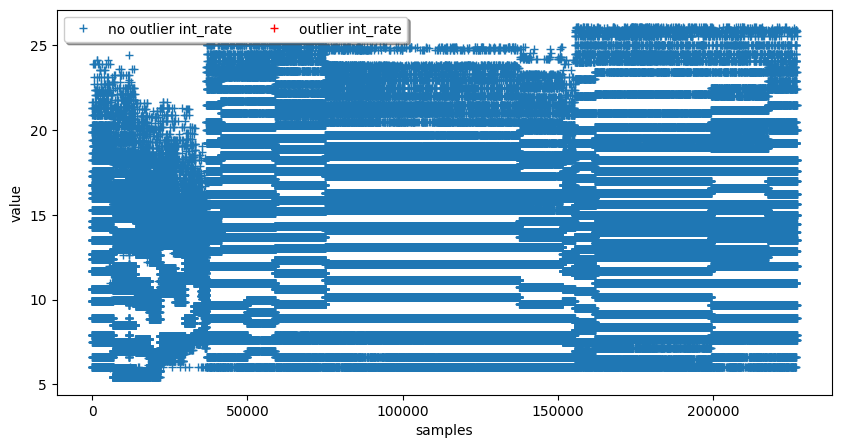

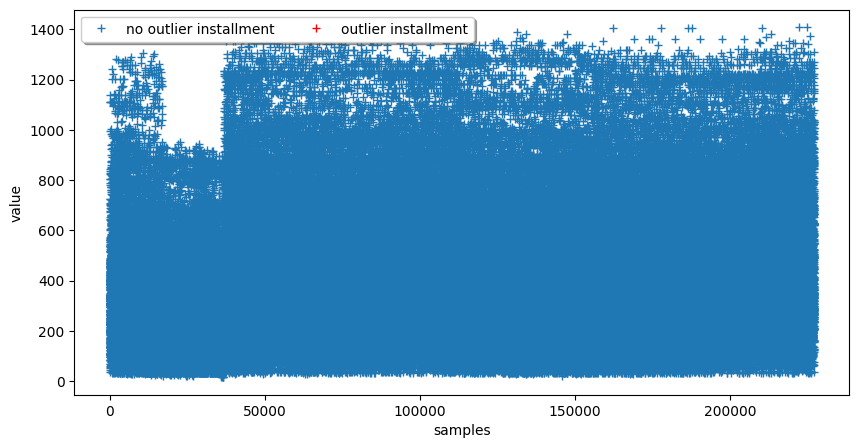

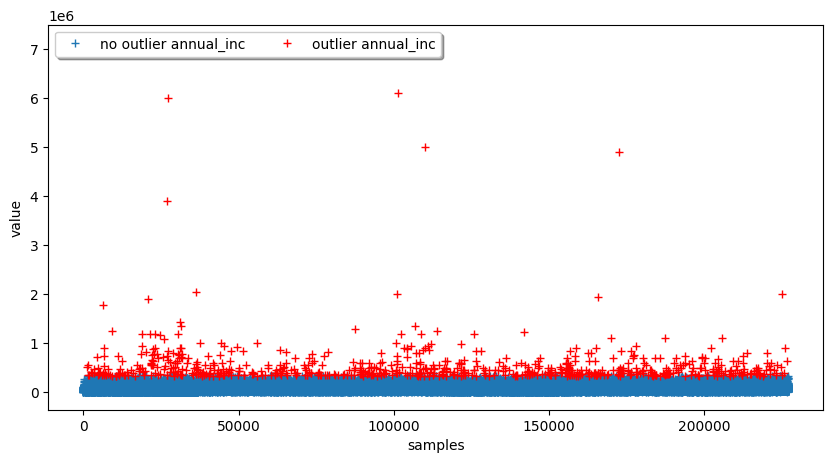

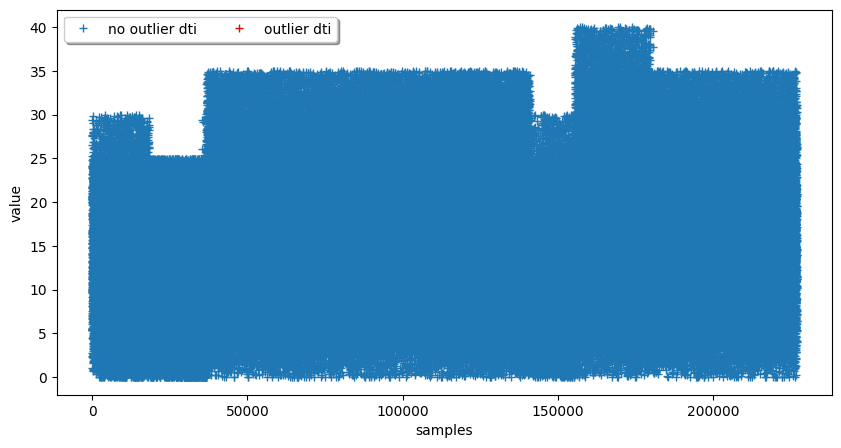

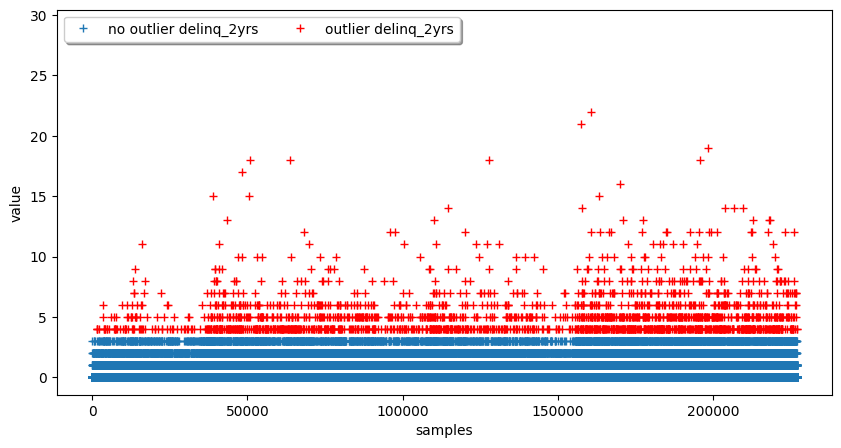

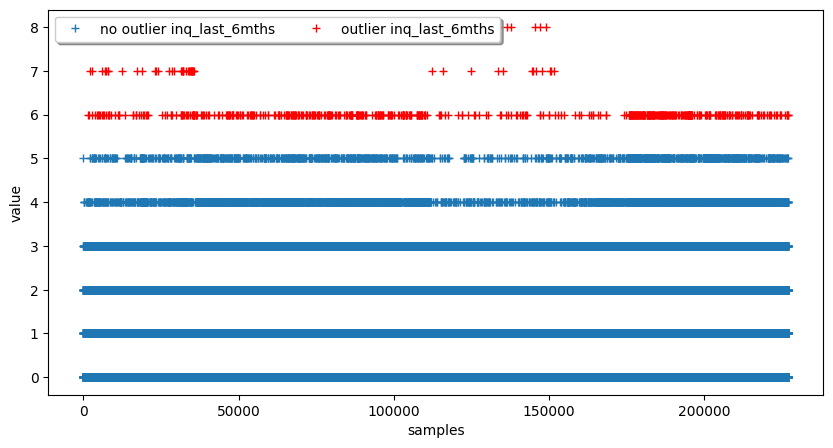

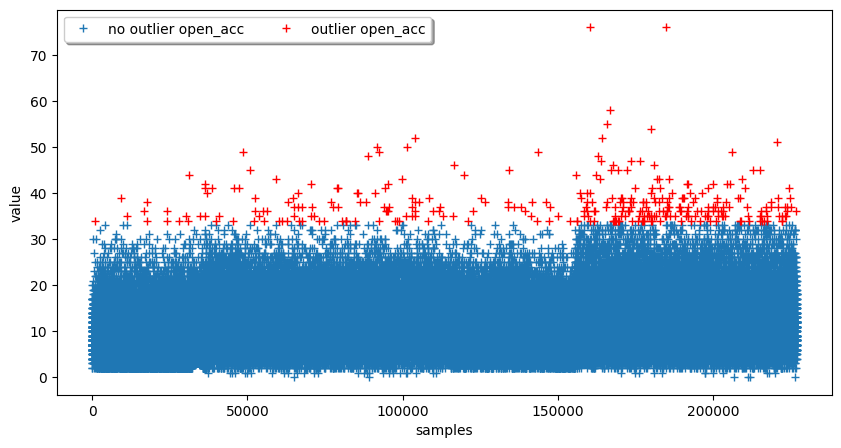

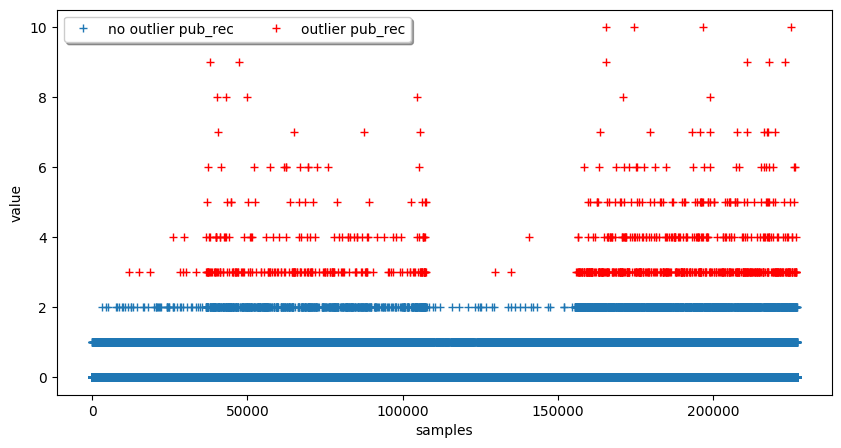

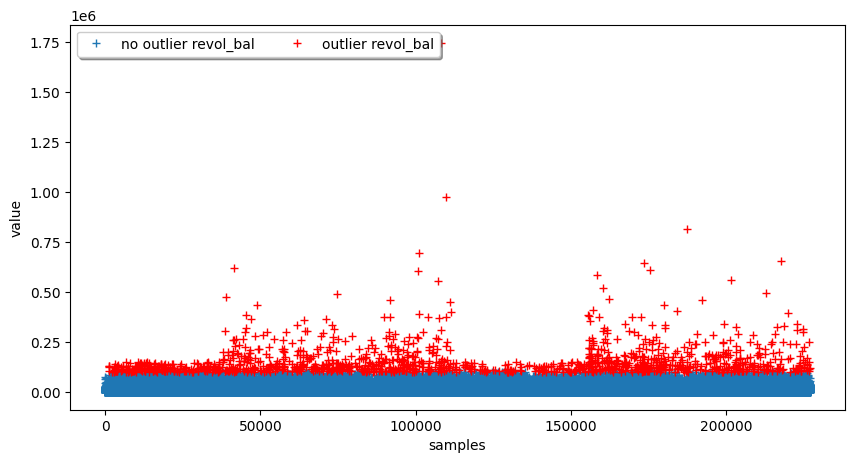

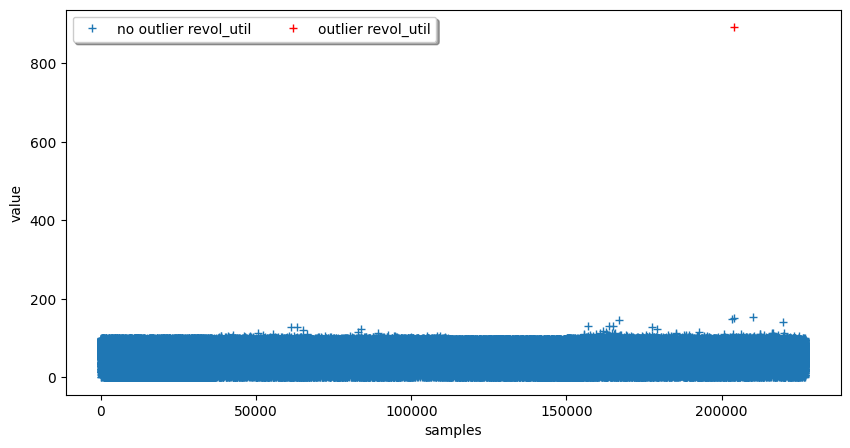

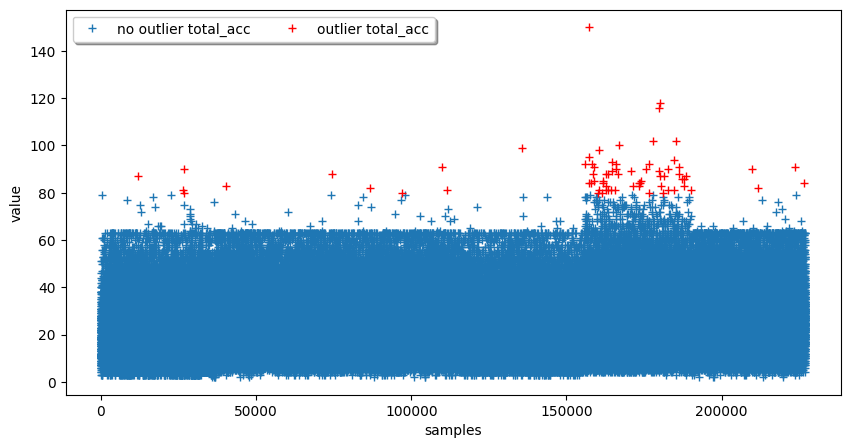

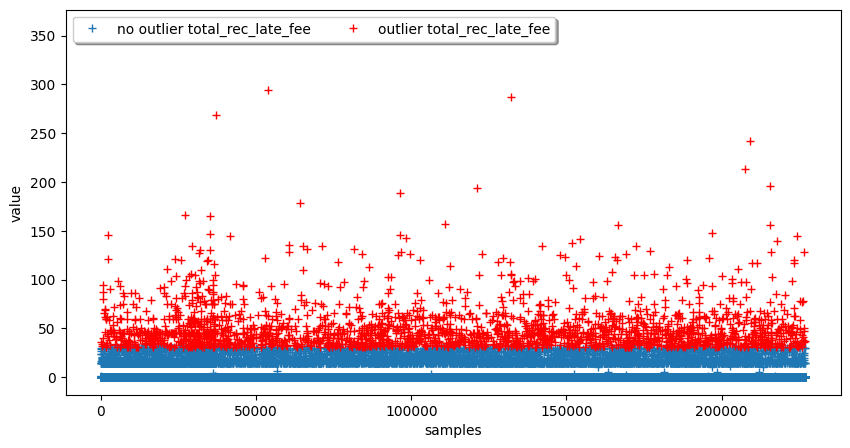

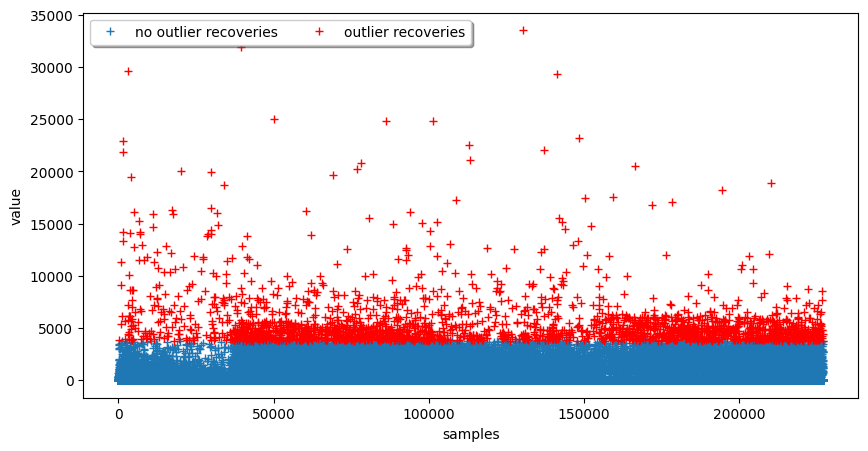

In [33]:
# Marking outlier for numeric columns using chauvenet
for col in outlier_cols:
    dataset = mark_outliers_chauvenet(loans, col)
    plot_binary_outliers(
        dataset=dataset, col=col, outlier_col=col + "_outlier", reset_index=False
    )

It can be seen that the **Chauvenet criterion** gives fewer outliers than the **IQR** method, for the sake of important data because too many are deleted or filled, the Chauvenet criterion is chosen as outlier detection. Next, the **outliers** that have been detected using the chauvenet criterion will be **removed**.

In [34]:
# Choose chauvenet for drop outliers
outliers_removed_df = loans.copy()
for col in outlier_cols:
    dataset = mark_outliers_chauvenet(loans, col)

    # Replace values marked as outliers with NaN
    dataset.loc[dataset[col + "_outlier"], col] = np.nan

    # Update the column in the original dataframe
    outliers_removed_df.loc[:, col] = dataset[col]

    n_outliers = len(dataset) - len(dataset[col].dropna())
    print(f"Removed {n_outliers} from {col}")

Removed 0 from loan_amnt
Removed 0 from int_rate
Removed 0 from installment
Removed 686 from annual_inc
Removed 0 from dti
Removed 1934 from delinq_2yrs
Removed 580 from inq_last_6mths
Removed 317 from open_acc
Removed 815 from pub_rec
Removed 1240 from revol_bal
Removed 1 from revol_util
Removed 72 from total_acc
Removed 2110 from total_rec_late_fee
Removed 2200 from recoveries


In [35]:
# Remove outliers
outliers_removed_df = outliers_removed_df.dropna(axis=0)
outliers_removed_df.reset_index(drop=True, inplace=True)

loans_df = outliers_removed_df.copy()

### Categorical columns to numeric

In [36]:
# Categorical columns
cat_columns = loans_df.select_dtypes(include=["object"]).columns
for col in cat_columns:
    print(loans_df[col].value_counts())
    print()

term
36 months    170086
60 months     47448
Name: count, dtype: int64

grade
B    67146
C    55652
A    37189
D    34434
E    15499
F     6162
G     1452
Name: count, dtype: int64

emp_length
10+ years    67311
2 years      21130
< 1 year     18830
3 years      18412
5 years      16492
1 year       15148
4 years      14653
6 years      13661
7 years      12832
8 years      10524
9 years       8541
Name: count, dtype: int64

home_ownership
MORTGAGE    106203
RENT         93597
OWN          17562
OTHER          131
NONE            40
ANY              1
Name: count, dtype: int64

verification_status
Not Verified       78771
Verified           76954
Source Verified    61809
Name: count, dtype: int64

loan_status
1    173649
0     43885
Name: count, dtype: int64

purpose
debt_consolidation    127550
credit_card            43655
home_improvement       12212
other                  12147
major_purchase          5397
small_business          4171
car                     3227
medical            

In [37]:
loans_df.term[0]

' 36 months'

There is **whitespace** in front of the value of the `term` column (`" 36 months"`), so the **whitespace** will be handled

In [38]:
# Handling whitespace in term value
loans_df["term"] = loans_df["term"].str.strip()

In [39]:
loans_df.groupby("grade")["loan_status"].sum()

grade
A    34602
B    57533
C    43003
D    24269
E     9778
F     3644
G      820
Name: loan_status, dtype: object

Convert the `grade` and `emp_length` column values to numeric. These columns will be filled with ordinal numbers because they are ranked. The selection of rankings in the grade column is based on the order above according to the alphabet with `grade` **A** having the **most good loans**.

In [40]:
# Mapping grade and emp_length columns
mapping_dict = {
    "grade": {
        "A": 7,
        "B": 6,
        "C": 5,
        "D": 4,
        "E": 3,
        "F": 2,
        "G": 1,
    },
    "emp_length": {
        "< 1 year": 0,
        "1 year": 1,
        "2 years": 2,
        "3 years": 3,
        "4 years": 4,
        "5 years": 5,
        "6 years": 6,
        "7 years": 7,
        "8 years": 8,
        "9 years": 9,
        "10+ years": 10,
    },
}

loans_df = loans_df.replace(mapping_dict)
loans_df.head(3)

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,zip_code,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_late_fee,recoveries
0,5000,36 months,10.650,162.870,6,10,RENT,24000.000,Verified,1,credit_card,860xx,27.650,0.000,1.000,3.000,0.000,13648.000,83.700,9.000,0.000,0.000
1,2500,60 months,15.270,59.830,5,0,RENT,30000.000,Source Verified,0,car,309xx,1.000,0.000,5.000,3.000,0.000,1687.000,9.400,4.000,0.000,117.080
2,2400,36 months,15.960,84.330,5,10,RENT,12252.000,Not Verified,1,small_business,606xx,8.720,0.000,2.000,2.000,0.000,2956.000,98.500,10.000,0.000,0.000


For the `term`, `home_ownership`, `verification_status`, and `purpose` columns, each column is converted to a 0/1 variable as many different values

In [41]:
# Dummy columns
dummy_cols = ["term", "home_ownership", "verification_status", "purpose"]
dummy_df = pd.get_dummies(loans_df[dummy_cols], dtype="int64")
loans_df = pd.concat([loans_df, dummy_df], axis=1)
loans_df = loans_df.drop(dummy_cols, axis=1)

loans_df.head(3)

,loan_amnt,int_rate,installment,grade,emp_length,annual_inc,loan_status,zip_code,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_late_fee,recoveries,term_36 months,term_60 months,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,5000,10.650,162.870,6,10,24000.000,1,860xx,27.650,0.000,1.000,3.000,0.000,13648.000,83.700,9.000,0.000,0.000,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2500,15.270,59.830,5,0,30000.000,0,309xx,1.000,0.000,5.000,3.000,0.000,1687.000,9.400,4.000,0.000,117.080,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2400,15.960,84.330,5,10,12252.000,1,606xx,8.720,0.000,2.000,2.000,0.000,2956.000,98.500,10.000,0.000,0.000,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


for the `zip_code` column is handled by converting it to a hundreds integer

In [42]:
def zip_formatted(row):
    row = row.lstrip("0")
    if len(str(row)) == 1:
        row = str(row) + "00"
    elif len(str(row)) == 2:
        row = str(row) + "0"

    return int(row)

In [43]:
# Convert zip_code column
loans_df["zip_code"] = loans_df["zip_code"].str.rstrip("xx")

loans_df["zip_code"] = loans_df["zip_code"].apply(zip_formatted)

In [44]:
# Make a copy file
loans_cleaned = loans_df.copy()


In [45]:
# Checking imbalanced data
loans_cleaned["loan_status"].value_counts() / loans_cleaned.shape[0]

loan_status
1   0.798
0   0.202
Name: count, dtype: float64

In [46]:
# Convert loan_status to int datatype
loans_cleaned["loan_status"] = loans_cleaned["loan_status"].astype("int64")

There is an imbalance of data between targets, to handle it **SMOTE** (*Synthetic Minority Oversampling Technique*) is used to oversample the target with a value of 0.

In [47]:
# Divide data into features and target
X = loans_cleaned.drop("loan_status", axis=1)
y = loans_cleaned["loan_status"]

# Handling imbalanced data using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Divide data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.30, random_state=42
)

## Data modelling

Standardize the feature data to equalize the scale

In [56]:
# Standardize
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

Feature reduction using **PCA** (*principal component analysis*). The goal is to reduce dimensional complexity, accelerate machine learning model building

In [132]:
# Determine the number of components that explain at least 95% of the variance
pca = PCA().fit(X_train)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.95) + 1

print(f"Number of components explaining at least 95% variance: {n_components}")

Number of components explaining at least 95% variance: 34


In [133]:
# Apply PCA
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

**Models :**
- Logistic Regression
> Logistic Regression is a good choice for "bad" or "good" classification due to its simplicity and speed. This model is particularly effective for binary classification problems and provides probabilities for each class, allowing for flexible threshold determination.
- K-Nearest Neighbors (KNN)
> KNN is very simple and easy to implement, using the distance between data to determine the class.
- Random Forest
> Random Forest is excellent for "bad" or "good" classification because it is an ensemble method that combines many decision trees to improve accuracy and reduce overfitting.

In [134]:
# Define models
models = {
    "LR": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "RF": RandomForestClassifier(),
}

In [139]:
# Define hyperparameters for GridSearch
param_grids = {
    "LR": {
        "C": [0.1, 1, 10, 100]
    },
    "KNN": {
        "n_neighbors": [5, 10, 20],
        "weights": ["uniform", "distance"]
    },
    "RF": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "max_features": ["sqrt", "log2"]
    },
}

The model will be evaluated using *accuracy*, *precision*, *recall*, and *ROC-AUC*.

In [59]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    return accuracy, precision, recall, roc_auc

In [140]:
# GridSearchCV for the best model
# Perform GridSearchCV and evaluate models
best_models = {}
for name, model in models.items():
    print(f"Training {model}...")
    grid_search = GridSearchCV(
        model, param_grids[name], cv=5, scoring="roc_auc", n_jobs=-1
    )

    start_time = time.time()
    grid_search.fit(X_train_pca, y_train)
    end_time = time.time()

    best_models[name] = grid_search.best_estimator_
    print(f"Time taken for {model}: {end_time - start_time:.2f} seconds")
    print("-" * 50)

# Evaluate the best models
best_results = {}
for name, model in best_models.items():
    best_results[name] = evaluate_model(model, X_test_pca, y_test)

# Display best results
best_results_df = pd.DataFrame(
    best_results, index=["Accuracy", "Precision", "Recall", "ROC-AUC"]
)
print("Best Models Results after GridSearchCV")
print(best_results_df)

Training LogisticRegression()...
Time taken for LogisticRegression(): 29.44 seconds
--------------------------------------------------
Training KNeighborsClassifier()...
Time taken for KNeighborsClassifier(): 863.67 seconds
--------------------------------------------------
Training RandomForestClassifier()...
Time taken for RandomForestClassifier(): 8455.96 seconds
--------------------------------------------------
Best Models Results after GridSearchCV
             LR   KNN    RF
Accuracy  0.916 0.883 0.898
Precision 0.862 0.822 0.840
Recall    0.990 0.977 0.984
ROC-AUC   0.955 0.936 0.946


In [141]:
# Look at the best models from the grid search results
for name, model in best_models.items():
  print(f"{name:5}: {model}")

LR   : LogisticRegression(C=1)
KNN  : KNeighborsClassifier(n_neighbors=20, weights='distance')
RF   : RandomForestClassifier(max_depth=20, n_estimators=200)


From the roc auc value, it can be seen that the logistic regression model has the best ability to distinguish good loans from risky loans at 0.955, followed by the random forest and KNN models at 0.946 and 0.936 respectively.

## Evaluation

#### Train best models to data before **PCA**

In [57]:
# Transform X
X_scaled = scalar.transform(X)

results = {}

In [60]:
# Logistic Regression
LR = LogisticRegression(C=1)

# Fitting model
LR.fit(X_train, y_train)

results["LR"] = evaluate_model(LR, X_test, y_test)

In [103]:
# K-Nearest Neighbors
KNN = KNeighborsClassifier(n_neighbors=20, weights='distance')

# Fitting model
KNN.fit(X_train, y_train)

results["KNN"] = evaluate_model(KNN, X_test, y_test)

In [104]:
# Random Forest
RF = RandomForestClassifier(max_features='log2', n_estimators=200, n_jobs=-1)

# Fitting model
RF.fit(X_train, y_train)

results["RF"] = evaluate_model(RF, X_test, y_test)

In [105]:
results_df = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "ROC-AUC"])
results_df

,LR,KNN,RF
Accuracy,0.916,0.885,0.928
Precision,0.861,0.825,0.880
Recall,0.992,0.979,0.992
ROC-AUC,0.956,0.937,0.963


**Summary :**
- **Accuracy** : The random forest model has the highest accuracy rate among the three models at 0.928, meaning that the model is able to **correctly predict** 92.8% of all observations. On the other hand, the logistic regression and knn models were able to correctly predict 91.6% and 88.5% of all observations.
- **Precision** : The largest precision was also obtained by the random forest model with a value of 0.880, meaning that of **all good loan predictions** made by the model, 88% were correct. While the logistic regression and knn models were correct for 86.1% and 82.5% of the all good loan predictions made.
- **Recall** : The Logistic regression and random forest models have almost the same (or possibly the same) value in the recall metric, which is 0.992, meaning that the models are able to detect 99.2% **of all actual good loan cases**. Meanwhile, the KK model was able to detect 97.9% of all actual good loan cases.
- **ROC-AUC** : The random forest model has the best ability to **distinguish between good loans and risky loans** with an auc value of 0.963. On the other hand, the logistic regression and knn models have auc values of 0.956 and 0.937.

In [110]:
# Function for visualize between good loans vs risky loans
def comparing_loans(model_name, model):
  # Prediction for X scaled
  y_pred = model.predict(X_scaled)

  pct = (pd.Series(y_pred).value_counts() / y_pred.shape[0])*100

  # Pie
  plt.pie(pct, autopct="%.3f%%", explode=[0, 0.1])
  plt.legend(["Good Loans", "Risky Loans"])
  plt.title(f"Good Loans vs Risky Loans\n{model_name}")
  plt.show()

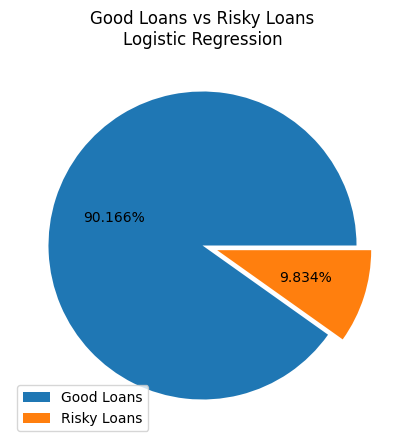

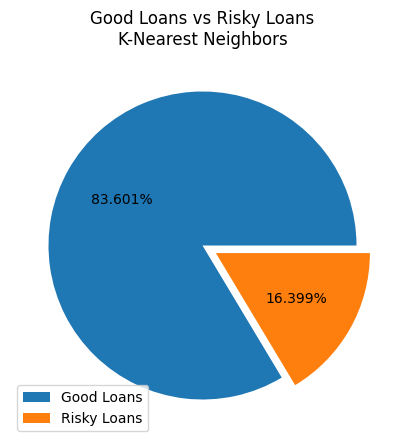

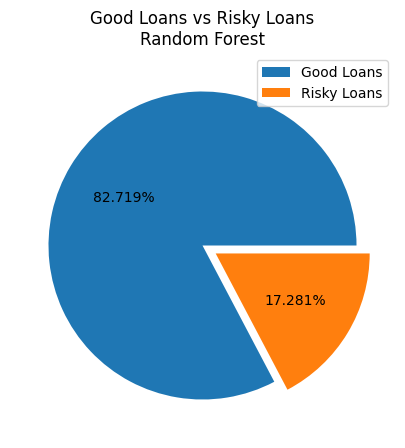

In [111]:
# Visualize comparison
models_final = {
  "Logistic Regression" : LR,
  "K-Nearest Neighbors" : KNN, 
  "Random Forest" : RF
}

# Comparison of good loans and risky loans
for name, model in models_final.items():
  comparing_loans(name, model)

## Conclusion
- **Logistic Regression** : If the logistic regression model is chosen in classifying good and risky loans, this data will consist of **90.166% good loans** and **9.834% risky loans** with an accuracy of 91.6%, precision of 86.1%, recall of 99.2%, and ROC AUC of 0.956.
- **K-Nearest Neighbors** : Ff the knn model is selected in classifying good and risky loans, this data will consist of **83.601% good loans** and **16.399% risky loans** with 88.5% accuracy, 82.5% precision, 97.9% recall, and ROC AUC 0.937.
- **Random Forest** : if the random forest model is chosen in classifying good and risky loans, this data will consist of **82.719% good loans** and **17.281% risky loans** with an accuracy of 92.8%, precision of 88%, recall of 99.2%, and ROC AUC of 0.963.

Overall the model is able to make predictions that are very accurate and consistent.

#### Feature Importance

In [94]:
# Feature importances
importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]:.4f})")

Feature ranking:
1. recoveries (0.2443)
2. grade (0.0709)
3. int_rate (0.0514)
4. inq_last_6mths (0.0458)
5. term_36 months (0.0389)
6. dti (0.0343)
7. annual_inc (0.0314)
8. revol_util (0.0302)
9. zip_code (0.0295)
10. installment (0.0290)
11. home_ownership_MORTGAGE (0.0287)
12. revol_bal (0.0278)
13. verification_status_Not Verified (0.0271)
14. verification_status_Verified (0.0270)
15. open_acc (0.0265)
16. verification_status_Source Verified (0.0261)
17. home_ownership_RENT (0.0259)
18. loan_amnt (0.0256)
19. total_acc (0.0246)
20. emp_length (0.0235)
21. total_rec_late_fee (0.0222)
22. term_60 months (0.0192)
23. delinq_2yrs (0.0179)
24. home_ownership_OWN (0.0151)
25. purpose_credit_card (0.0142)
26. pub_rec (0.0135)
27. purpose_debt_consolidation (0.0119)
28. purpose_home_improvement (0.0048)
29. purpose_other (0.0045)
30. purpose_major_purchase (0.0019)
31. purpose_small_business (0.0015)
32. purpose_car (0.0010)
33. purpose_medical (0.0009)
34. purpose_wedding (0.0008)
35. pu

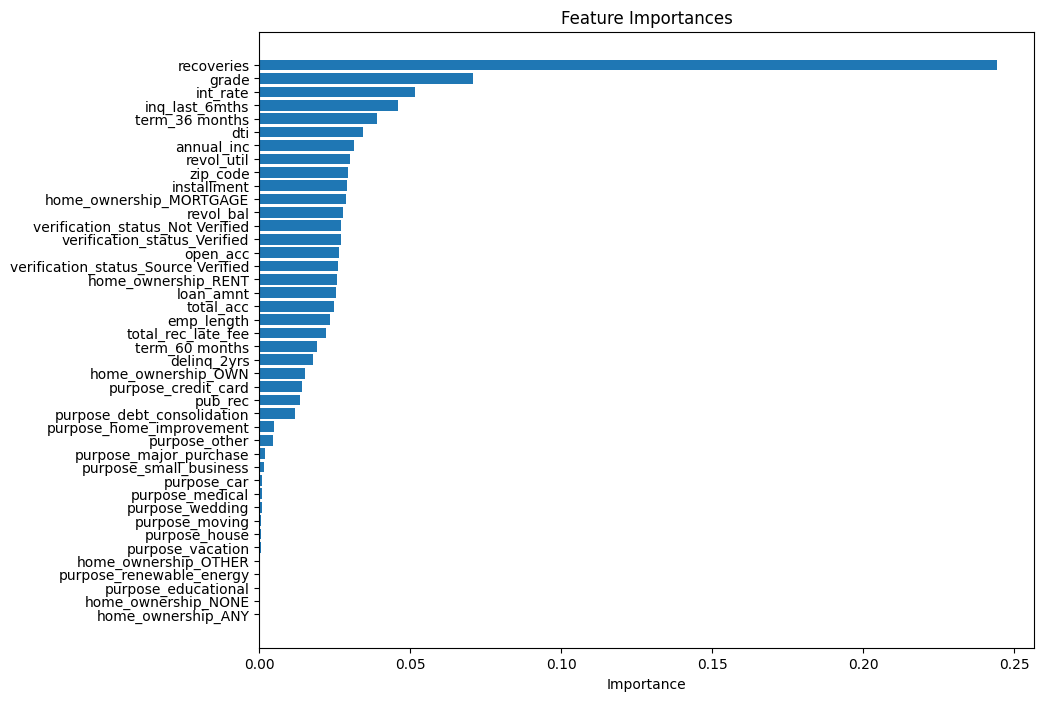

In [95]:
# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), [feature_names[i] for i in indices])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.show()